In [52]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.templates.default = "seaborn"
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble  import StackingRegressor
from sklearn.model_selection  import KFold
from sklearn.preprocessing  import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression as OLS
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.datasets import fetch_dataset

# Configuration warnings
# ==============================================================================
import warnings


In [22]:
from sklearn.datasets import fetch_openml
import polars as pl

pl.Config.set_fmt_str_lengths(20)

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
df = bike_sharing.frame
df = pl.DataFrame({col: df[col].to_numpy() for col in df.columns})

In [24]:
lagged_df = df.select(
    "count",
    *[pl.col("count").shift(i).alias(f"lagged_count_{i}h") for i in [1, 2, 3]],
    lagged_count_1d=pl.col("count").shift(24),
    lagged_count_1d_1h=pl.col("count").shift(24 + 1),
    lagged_count_7d=pl.col("count").shift(7 * 24),
    lagged_count_7d_1h=pl.col("count").shift(7 * 24 + 1),
    lagged_mean_24h=pl.col("count").shift(1).rolling_mean(24),
    lagged_max_24h=pl.col("count").shift(1).rolling_max(24),
    lagged_min_24h=pl.col("count").shift(1).rolling_min(24),
    lagged_mean_7d=pl.col("count").shift(1).rolling_mean(7 * 24),
    lagged_max_7d=pl.col("count").shift(1).rolling_max(7 * 24),
    lagged_min_7d=pl.col("count").shift(1).rolling_min(7 * 24),
)
lagged_df.tail(10)

shape: (10, 14)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ count ┆ lagged_cou ┆ lagged_cou ┆ lagged_cou ┆ … ┆ lagged_mi ┆ lagged_me ┆ lagged_ma ┆ lagged_mi │
│ ---   ┆ nt_1h      ┆ nt_2h      ┆ nt_3h      ┆   ┆ n_24h     ┆ an_7d     ┆ x_7d      ┆ n_7d      │
│ i64   ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│       ┆ i64        ┆ i64        ┆ i64        ┆   ┆ i64       ┆ f64       ┆ i64       ┆ i64       │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 247   ┆ 203        ┆ 224        ┆ 157        ┆ … ┆ 1         ┆ 67.732143 ┆ 271       ┆ 1         │
│ 315   ┆ 247        ┆ 203        ┆ 224        ┆ … ┆ 1         ┆ 68.785714 ┆ 271       ┆ 1         │
│ 214   ┆ 315        ┆ 247        ┆ 203        ┆ … ┆ 1         ┆ 70.386905 ┆ 315       ┆ 1         │
│ 164   ┆ 214        ┆ 315        ┆ 247        ┆ … ┆ 1         ┆ 71.464286 ┆ 315       ┆ 1         │
│ 122   ┆ 164        ┆ 214        ┆ 315        ┆ … ┆ 1         ┆ 72.244048 ┆ 315       ┆ 1         │
│ 119   ┆ 122        ┆ 164        ┆ 214        ┆ … ┆ 1         ┆ 72.815476 ┆ 315       ┆ 1         │
│ 89    ┆ 119        ┆ 122        ┆ 164        ┆ … ┆ 1         ┆ 73.369048 ┆ 315       ┆ 1         │
│ 90    ┆ 89         ┆ 119        ┆ 122        ┆ … ┆ 1         ┆ 73.791667 ┆ 315       ┆ 1         │
│ 61    ┆ 90         ┆ 89         ┆ 119        ┆ … ┆ 1         ┆ 74.190476 ┆ 315       ┆ 1         │
│ 49    ┆ 61         ┆ 90         ┆ 89         ┆ … ┆ 1         ┆ 74.422619 ┆ 315       ┆ 1         │
└───────┴────────────┴────────────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [25]:
lagged_df = lagged_df.drop_nulls()
X = lagged_df.drop("count")
y = lagged_df["count"]
print("X shape: {}\ny shape: {}".format(X.shape, y.shape))

X shape: (17210, 13)
y shape: (17210,)


In [26]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=3,  # to keep the notebook fast enough on common laptops
    gap=48,  # 2 days data gap between train and test
    max_train_size=10000,  # keep train sets of comparable sizes
    test_size=3000,  # for 2 or 3 digits of precision in scores
)
all_splits = list(ts_cv.split(X, y))

In [27]:
train_idx, test_idx = all_splits[0]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]

In [54]:
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100)),
    ('dt', DecisionTreeRegressor(max_depth=5)),
    ('ols', OLS()),
    ('xgb', XGBRegressor()),
    ('lgbm', LGBMRegressor()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100))),
    ('kr', KernelRidge()),
    ('lasso', LassoCV())
    ]

base_models = [model for _, model in estimators]
for model in base_models:
    model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2637
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 13
[LightGBM] [Info] Start training from score 147.470228


In [55]:
from sklearn.datasets import fetch_openml
import polars as pl
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import beta

pl.Config.set_fmt_str_lengths(20)

# Data loading and preprocessing
bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
df = bike_sharing.frame
df = pl.DataFrame({col: df[col].to_numpy() for col in df.columns})

lagged_df = df.select(
    "count",
    *[pl.col("count").shift(i).alias(f"lagged_count_{i}h") for i in [1, 2, 3]],
    lagged_count_1d=pl.col("count").shift(24),
    lagged_count_1d_1h=pl.col("count").shift(24 + 1),
    lagged_count_7d=pl.col("count").shift(7 * 24),
    lagged_count_7d_1h=pl.col("count").shift(7 * 24 + 1),
    lagged_mean_24h=pl.col("count").shift(1).rolling_mean(24),
    lagged_max_24h=pl.col("count").shift(1).rolling_max(24),
    lagged_min_24h=pl.col("count").shift(1).rolling_min(24),
    lagged_mean_7d=pl.col("count").shift(1).rolling_mean(7 * 24),
    lagged_max_7d=pl.col("count").shift(1).rolling_max(7 * 24),
    lagged_min_7d=pl.col("count").shift(1).rolling_min(7 * 24),
)

lagged_df = lagged_df.drop_nulls()
X = lagged_df.drop("count")
y = lagged_df["count"]

# Time series split
ts_cv = TimeSeriesSplit(
    n_splits=3,
    gap=48,
    max_train_size=10000,
    test_size=3000,
)
all_splits = list(ts_cv.split(X, y))

train_idx, test_idx = all_splits[0]
X_train, X_test = X[train_idx, :].to_numpy(), X[test_idx, :].to_numpy()
y_train, y_test = y[train_idx].to_numpy(), y[test_idx].to_numpy()

# Assuming base_models are defined elsewhere
for model in base_models:
    model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2637
[LightGBM] [Info] Number of data points in the train set: 8162, number of used features: 13
[LightGBM] [Info] Start training from score 147.470228


/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [56]:
class AdaptiveEnsemble:
    def __init__(self, models, learning_rate=0.1):
        self.models = models
        self.n_models = len(models)
        self.weights = np.ones(self.n_models) / self.n_models
        self.alpha = np.ones(self.n_models)
        self.beta = np.ones(self.n_models)
        self.learning_rate = learning_rate
    
    def predict(self, t):
        t = t.to_numpy() if hasattr(t, 'to_numpy') else t
        t = t.reshape(1, -1) if t.ndim == 1 else t
        sampled_weights = np.array([beta.rvs(a, b) for a, b in zip(self.alpha, self.beta)])
        normalized_weights = sampled_weights / np.sum(sampled_weights)
        predictions = np.array([model.predict(t) for model in self.models])
        return np.dot(normalized_weights, predictions)
    
    def update(self, t, y_true):
        t = t.to_numpy() if hasattr(t, 'to_numpy') else t
        t = t.reshape(1, -1) if t.ndim == 1 else t
        y_pred = self.predict(t)
        error = np.abs(y_true - y_pred)
        
        # Update performance distributions
        for i, model in enumerate(self.models):
            model_error = np.abs(y_true - model.predict(t))
            if model_error < error:
                self.alpha[i] += 1
            else:
                self.beta[i] += 1
        
        # Weight update with gradient clipping
        grad = np.array([y_true - model.predict(t).item() for model in self.models])
        grad = np.clip(grad, -1, 1)  # Clip gradient to prevent extreme updates
        self.weights += self.learning_rate * grad
        self.weights = np.clip(self.weights, 1e-3, None)  # Prevent weights from becoming zero
        self.weights /= np.sum(self.weights)
    
    def get_weights(self):
        return self.weights.copy()



# Assuming base_models are defined
ensemble = AdaptiveEnsemble(base_models, learning_rate=0.1)

mse_history = []
weight_history = []

n_points = len(y_test)
for i in range(n_points):
    y_pred = ensemble.predict(X_test[i:i+1])
    ensemble.update(X_test[i:i+1], y_test[i])
    
    mse = np.mean((y_test[:i+1] - ensemble.predict(X_test[:i+1]))**2)
    mse_history.append(mse)
    weight_history.append(ensemble.weights.copy())

/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/lightgbm/basic.py:720: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.

/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/lightgbm/basic.py:720: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.

/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/lightgbm/basic.py:720: UserWarning:

Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.

/Users/joepaul/Library/Caches/pypoetry/virtualenvs/conformalprediction-88YJ5nlB-py3.12/lib/python3.12/site-packages/lightgbm/basic.py:720: UserWarning:

Usage of np.ndarray subset (sliced da

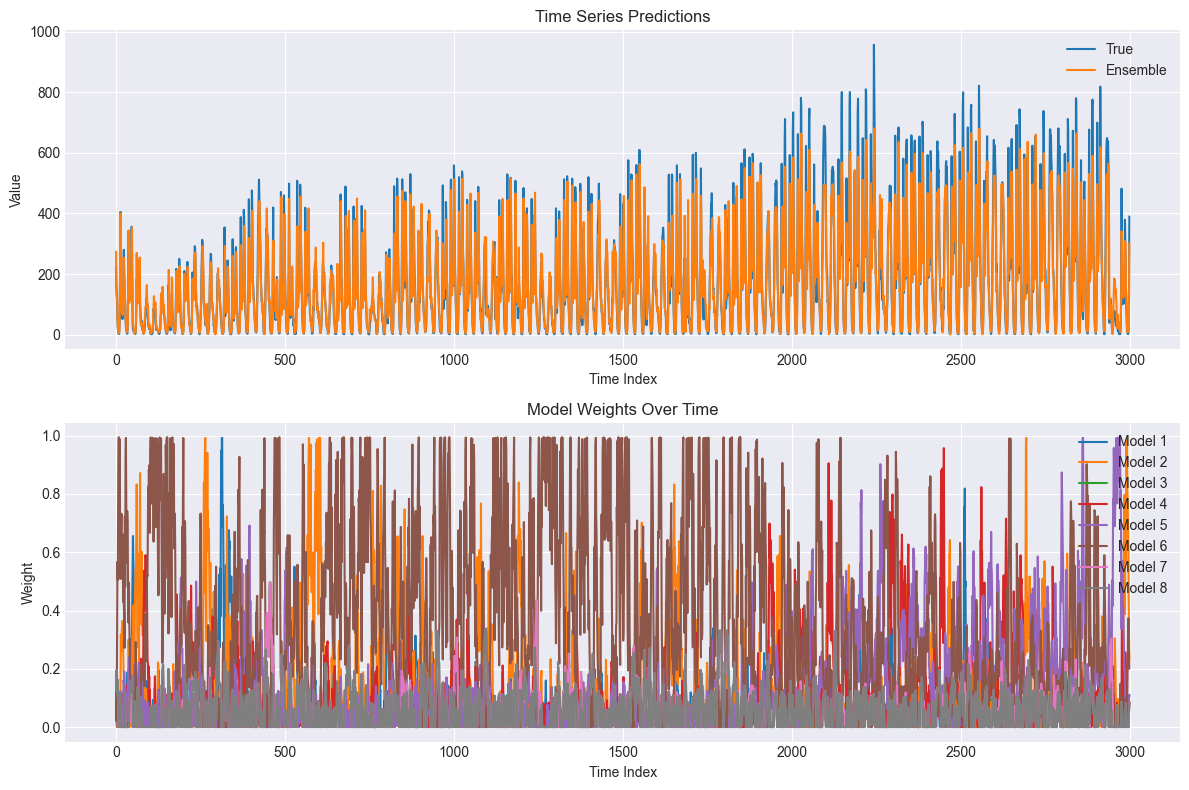

Final model weights: [0.11085194 0.23078169 0.08666149 0.08666149 0.11085194 0.20086845
 0.08666149 0.08666149]
Final MSE: 3068.8100610614433


In [57]:
# Assuming X_test_np, y_test_np, ensemble, and models are defined

# Create a time index for plotting
time_index = np.arange(len(y_test))

# Plotting results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time_index, y_test, label='True')
plt.plot(time_index, ensemble.predict(X_test), label='Ensemble')
# for i, model in enumerate(ensemble.models):
#     plt.plot(time_index, model.predict(X_test), label=f'Model {i+1}', alpha=0.5)
plt.legend()
plt.title('Time Series Predictions')
plt.xlabel('Time Index')
plt.ylabel('Value')

plt.subplot(2, 1, 2)
weight_history = np.array(weight_history)
for i in range(ensemble.n_models):
    plt.plot(time_index, weight_history[:, i], label=f'Model {i+1}')
plt.legend()
plt.title('Model Weights Over Time')
plt.xlabel('Time Index')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()

print("Final model weights:", ensemble.weights)
print("Final MSE:", mse_history[-1])

In [58]:
print(weight_history)

[[0.125      0.125      0.125      ... 0.125      0.125      0.125     ]
 [0.02160905 0.02160905 0.19448149 ... 0.02160905 0.19448149 0.19448149]
 [0.07241259 0.00059545 0.17535017 ... 0.07241259 0.17535017 0.17535017]
 ...
 [0.0791603  0.46773269 0.00078323 ... 0.37081378 0.00078323 0.00078323]
 [0.0995335  0.31540705 0.05599068 ... 0.26156321 0.05599068 0.05599068]
 [0.11085194 0.23078169 0.08666149 ... 0.20086845 0.08666149 0.08666149]]
